## Start by importing the necessary Python libraries and the dataset:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [2]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Now let’s see how to visualize this data. Data visualization is crucial to recognize the underlying patterns to properly train the machine learning model:

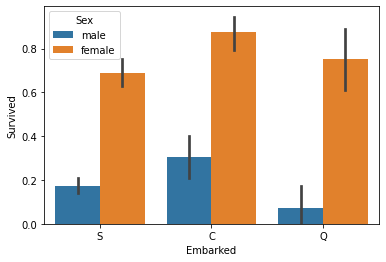

In [4]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train)
plt.show()

## Data Cleaning and Transformation:


Now the next step is to clean and transform data according to the output that we need. Here are the steps that I will consider in this step:

1. To avoid overfitting, I’m going to group people into logical human age groups.
2. Each booth begins with a letter. I bet this letter is much larger than the number that follows, let’s cut it off.
3. The tariff is another continuous value that should be simplified.
4. Extract the information from the “Name” function. Rather than using the full name, I extracted the last name and name prefix (Mr, Mrs etc.) and then added them as characteristics.
5. Finally, we need to remove unnecessary features.

In [5]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

In [6]:
data_train = transform_features(data_train)
data_test = transform_features(data_test)

In [7]:
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [8]:
data_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,male,Young Adult,0,0,1_quartile,N,"Kelly,",Mr.
1,893,3,female,Adult,1,0,1_quartile,N,"Wilkes,",Mrs.
2,894,2,male,Senior,0,0,2_quartile,N,"Myles,",Mr.
3,895,3,male,Young Adult,0,0,2_quartile,N,"Wirz,",Mr.
4,896,3,female,Student,1,1,2_quartile,N,"Hirvonen,",Mrs.


## Encoding Features:

The next step is to standardize the labels. The Label encoder converts each unique string into a number, making the data more flexible that can be used for various algorithms. The result is a scary array of numbers for humans, but beautiful for machines:

In [9]:
from sklearn import preprocessing

def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)

In [10]:
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [11]:
data_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,1,7,0,0,0,7,401,19
1,893,3,0,0,1,0,0,7,843,20
2,894,2,1,3,0,0,1,7,552,19
3,895,3,1,7,0,0,1,7,851,19
4,896,3,0,4,1,1,1,7,342,20


Now the next step is to divide the data into training and testing sets. Here I’ll be using one variable to store all the features minus the value we want to predict, and the other variable to store only the value we want to predict.

For this task, I’m going to randomly mix this data into four variables. In this case, I train 80% of the data, then I test the remaining 20%:

In [12]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

## Fitting and Tuning Machine Learning Algorithm:

Now is the time to determine which algorithm will provide the best model. In this task, I am going with the RandomForestClassifier, but you can also use any other classifier here, such as Support Vector Machines or Naive Bayes:

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       min_samples_split=3, n_estimators=6)

In [14]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8379888268156425


Print function to print accuracy for CV

In [15]:
def print_accuracy(outcomes):
    fold = 0
    for accuracy in outcomes:
        fold += 1
        print("Fold {0} accuracy: {1}".format(fold, accuracy*100))
    print("\nMean Accuracy: {0}".format(np.mean(outcomes)*100))

#### K-Fold CV

Now we need to use KFold cross-validation to validate our machine learning model. KFold cross-validation helps to understand that is our model good? This makes it possible to verify the efficiency of the algorithm using KFold. This will divide our data into 10 compartments, then run the algorithm using a different compartment as the test set for each iteration:

In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def run_kfold(clf):
    kf = KFold(10)
    outcomes = cross_val_score(clf, X_train, y_train, cv=kf)
    return outcomes

outcomes = run_kfold(clf)
print_accuracy(outcomes)

Fold 1 accuracy: 76.38888888888889
Fold 2 accuracy: 84.72222222222221
Fold 3 accuracy: 80.28169014084507
Fold 4 accuracy: 80.28169014084507
Fold 5 accuracy: 85.91549295774648
Fold 6 accuracy: 83.09859154929578
Fold 7 accuracy: 81.69014084507043
Fold 8 accuracy: 77.46478873239437
Fold 9 accuracy: 83.09859154929578
Fold 10 accuracy: 83.09859154929578

Mean Accuracy: 81.60406885758998


#### Stratified K-Fold CV

In [17]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 10)
outcomes = cross_val_score(clf, X_train, y_train, cv = skf)

print_accuracy(outcomes)

Fold 1 accuracy: 83.33333333333334
Fold 2 accuracy: 90.27777777777779
Fold 3 accuracy: 76.05633802816901
Fold 4 accuracy: 83.09859154929578
Fold 5 accuracy: 84.50704225352112
Fold 6 accuracy: 84.50704225352112
Fold 7 accuracy: 77.46478873239437
Fold 8 accuracy: 73.23943661971832
Fold 9 accuracy: 83.09859154929578
Fold 10 accuracy: 85.91549295774648

Mean Accuracy: 82.1498435054773


#### ShuffleSplit CV

In [18]:
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits = 10, test_size = num_test)
outcomes = cross_val_score(clf, X_train, y_train, cv = ss)

print_accuracy(outcomes)

Fold 1 accuracy: 83.21678321678321
Fold 2 accuracy: 77.62237762237763
Fold 3 accuracy: 79.02097902097903
Fold 4 accuracy: 80.41958041958041
Fold 5 accuracy: 79.02097902097903
Fold 6 accuracy: 86.01398601398601
Fold 7 accuracy: 79.02097902097903
Fold 8 accuracy: 79.72027972027972
Fold 9 accuracy: 80.41958041958041
Fold 10 accuracy: 83.91608391608392

Mean Accuracy: 80.83916083916083


## Testing the Model:

Now we need to predict on the actual test data:

In [19]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
